<a href="https://colab.research.google.com/github/amankhashbar/ML-Projects/blob/master/Credit_Card_Users_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Segmenting credit card users into groups using K-means clustering algorithms

We'll develop a customer segmentation algorithm for a targeted marketing ad campaign that is tailored to a specific group of people. 

The sample dataset that we'll be using summarizes the usage behavior of about 9000 active credit card holders during the last 6 months using 18 behavioral variables.

Dataset Used: [Credit Card Dataset for Clustering](https://www.kaggle.com/arjunbhasin2013/ccdata)

##Importing the dataset from kaggle to our notebook

In [40]:
#Make sure your kaggle api token is present in the 'content' folder

#Setup Kaggle DIR; copy json file ; chmod
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

#Install kaggle packages
!pip install -q kaggle
!pip install -q kaggle-cli

#list the dataset
!kaggle datasets list -s arjunbhasin2013/ccdata

#download the data
!kaggle datasets download -d arjunbhasin2013/ccdata

#unzip the data
!%%capture
!unzip ccdata.zip

kaggle.json
ref                     title                                size  lastUpdated          downloadCount  
----------------------  ----------------------------------  -----  -------------------  -------------  
arjunbhasin2013/ccdata  Credit Card Dataset for Clustering  340KB  2018-03-02 08:35:03          13021  
ccdata.zip: Skipping, found more recently modified local copy (use --force to force download)
/bin/bash: line 0: fg: no job control
Archive:  ccdata.zip
  inflating: CC GENERAL.csv          


##Importing the libraries

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


##Loading the dataset

In [89]:
creditcard_df = pd.read_csv('/content/CC GENERAL.csv')



In [46]:
# The dataset consists of the following features:

# CUSTID: Identification of Credit Card holder 
# BALANCE: Balance amount left in customer's account to make purchases
# BALANCE_FREQUENCY: How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
# PURCHASES: Amount of purchases made from account
# ONEOFFPURCHASES: Maximum purchase amount done in one-go
# INSTALLMENTS_PURCHASES: Amount of purchase done in installment
# CASH_ADVANCE: Cash in advance given by the user
# PURCHASES_FREQUENCY: How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
# ONEOFF_PURCHASES_FREQUENCY: How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
# PURCHASES_INSTALLMENTS_FREQUENCY: How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
# CASH_ADVANCE_FREQUENCY: How frequently the cash in advance being paid
# CASH_ADVANCE_TRX: Number of Transactions made with "Cash in Advance"
# PURCHASES_TRX: Number of purchase transactions made
# CREDIT_LIMIT: Limit of Credit Card for user
# PAYMENTS: Amount of Payment done by user
# MINIMUM_PAYMENTS: Minimum amount of payments made by user  
# PRC_FULL_PAYMENT: Percent of full payment paid by user
# TENURE: Tenure of credit card service for user

creditcard_df

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,C19186,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6
8946,C19187,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,NaN,0.000000,6
8947,C19188,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6
8948,C19189,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6


In [48]:
# Using describe() to get more statistical insights on our dataframe

# Mean balance is $1564 
# Balance frequency is frequently updated on average ~0.9
# Purchases average is $1000
# one off purchase average is ~$600
# Average purchases frequency is around 0.5
# average ONEOFF_PURCHASES_FREQUENCY, PURCHASES_INSTALLMENTS_FREQUENCY, and CASH_ADVANCE_FREQUENCY are generally low
# Average credit limit ~ 4500
# Percent of full payment is 15%
# Average tenure is 11 years

creditcard_df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


##Data Visualisation and Preprocessing

In [90]:
# Let's see if we have any missing data, luckily we don't have many!
creditcard_df.info()

# 18 features with 8950 points
# Some of the columns have NaN values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [91]:
# Number of missing values 
creditcard_df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

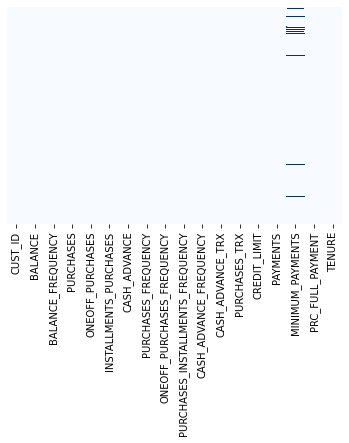

In [92]:
# Visualising the missing values using a heat map
sns.heatmap(creditcard_df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

In [93]:
# We'll fill up the missing elements with mean of the 'MINIMUM_PAYMENT'

creditcard_df.loc[(creditcard_df['MINIMUM_PAYMENTS'].isnull() == True), 'MINIMUM_PAYMENTS'] = creditcard_df['MINIMUM_PAYMENTS'].mean()

In [94]:
# Similarly for 'CREDIT_LIMIT' 
creditcard_df.loc[(creditcard_df['CREDIT_LIMIT'].isnull() == True), 'CREDIT_LIMIT'] = creditcard_df['CREDIT_LIMIT'].mean()

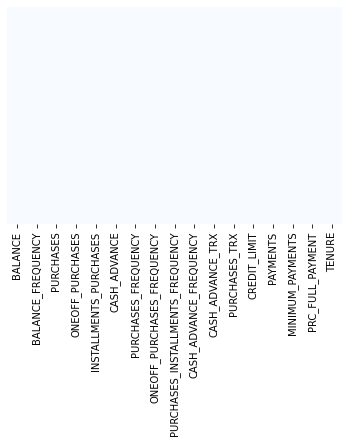

In [100]:
# Check if we still have any missing values
sns.heatmap(creditcard_df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

In [101]:
# Let's see if we have duplicated entries in the data
print(f'We have {creditcard_df.duplicated().sum()} duplicate entries.')

We have 0 duplicate entries.


In [ ]:
# Dropping customer id 
# cust_id = creditcard_df.iloc[:, 0]
# print(cust_id.head())
creditcard_df.drop('CUST_ID', axis = 1, inplace = True)

In [103]:
n = len(creditcard_df.columns)
print(f'We now have {n} columns.')

We now have 17 columns.


In [62]:
# Let's try to visualise the probabilty density of each variable
creditcard_df.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object')

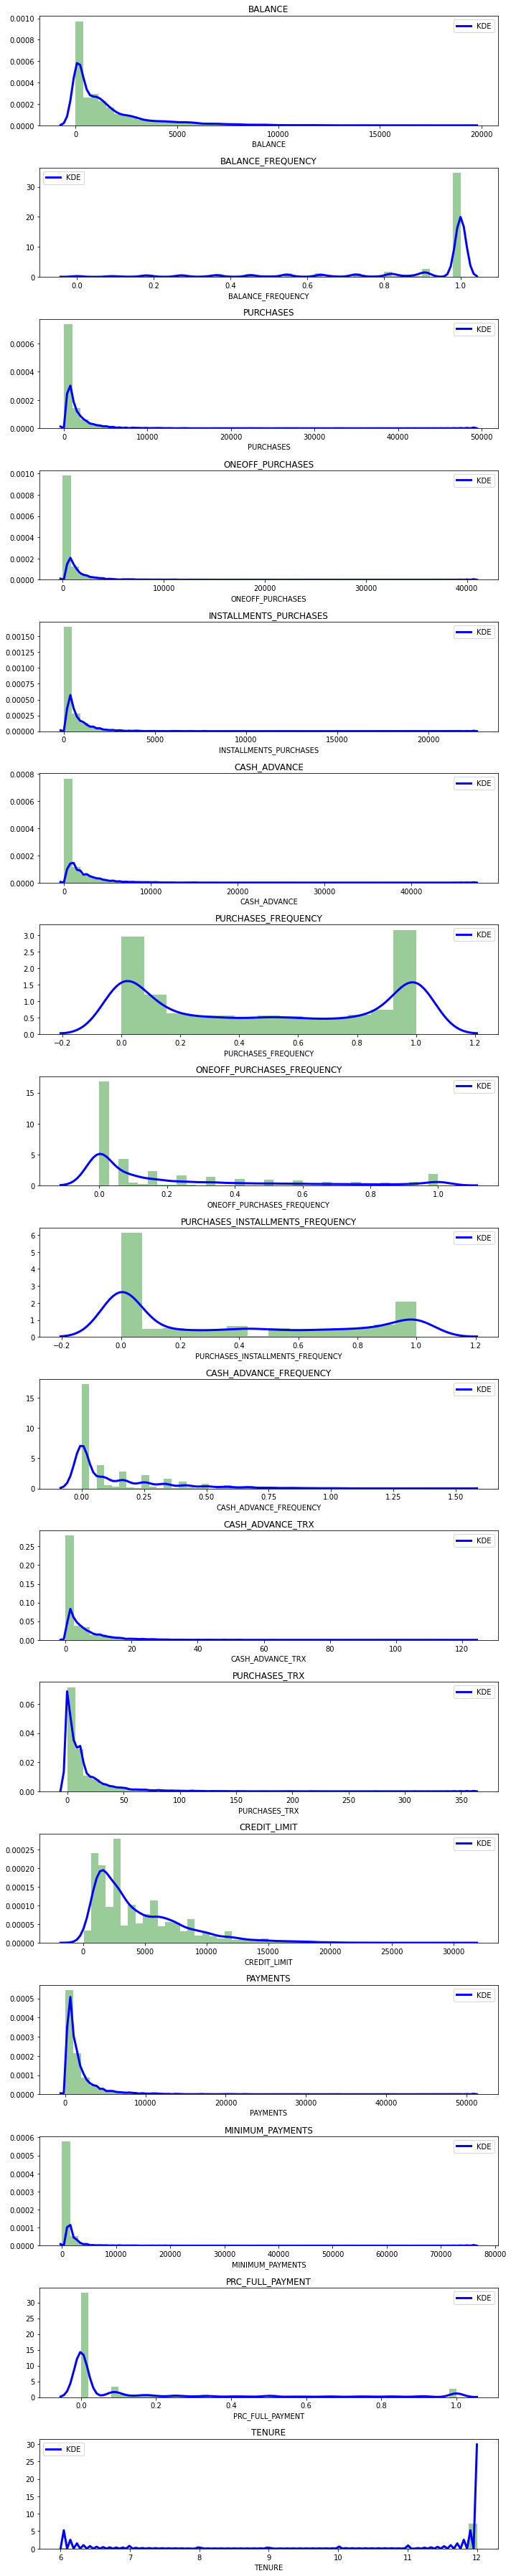

In [104]:
# distplot combines the matplotlib.hist function with seaborn kdeplot()
# KDE Plot represents the Kernel Density Estimate
# KDE is used for visualizing the Probability Density of a continuous variable. 
# KDE demonstrates the probability density at different values in a continuous variable. 

# Some Interesting Observations

# Mean of balance is $1500
# 'Balance_Frequency' for most customers is updated frequently ~1
# For 'PURCHASES_FREQUENCY', there are two distinct group of customers
# For 'ONEOFF_PURCHASES_FREQUENCY' and 'PURCHASES_INSTALLMENT_FREQUENCY' most users don't do one off puchases or installment purchases frequently 
# Very small number of customers pay their balance in full 'PRC_FULL_PAYMENT'~0
# Credit limit average is around $4500
# Most customers are ~11 years tenure

plt.figure(figsize=(10,50))
for i in range(len(creditcard_df.columns)):
  plt.subplot(17, 1, i+1)
  sns.distplot(creditcard_df[creditcard_df.columns[i]], kde_kws={"color": "b", "lw": 3, "label": "KDE"}, hist_kws={"color": "g"})
  plt.title(creditcard_df.columns[i])

plt.tight_layout()

##Finding the appropriate number of clusters using elbow method

In [111]:
# Let's scale the data first
scaler = StandardScaler()
creditcard_df_scaled = scaler.fit_transform(creditcard_df)
creditcard_df_scaled

array([[-0.73198937, -0.24943448, -0.42489974, ..., -0.31096755,
        -0.52555097,  0.36067954],
       [ 0.78696085,  0.13432467, -0.46955188, ...,  0.08931021,
         0.2342269 ,  0.36067954],
       [ 0.44713513,  0.51808382, -0.10766823, ..., -0.10166318,
        -0.52555097,  0.36067954],
       ...,
       [-0.7403981 , -0.18547673, -0.40196519, ..., -0.33546549,
         0.32919999, -4.12276757],
       [-0.74517423, -0.18547673, -0.46955188, ..., -0.34690648,
         0.32919999, -4.12276757],
       [-0.57257511, -0.88903307,  0.04214581, ..., -0.33294642,
        -0.52555097, -4.12276757]])

In [108]:
s = creditcard_df_scaled.shape
print(f'We have {s[0]} rows and {s[1]} columns.')

We have 8950 rows and 17 columns.


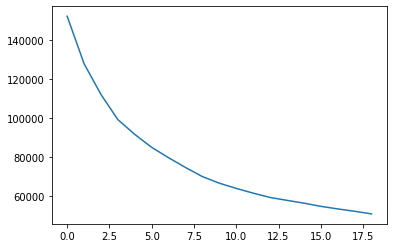

In [112]:
# Finding Within cluster sum of squares for range(1, 20)

wcss_scores = []

for i in range(1, 20):
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(creditcard_df_scaled)
  wcss_scores.append(kmeans.inertia_)

plt.plot(wcss_scores)

# From this we can observe that, 4th cluster seems to be forming the elbow of the curve. 
# However, the values does not reduce linearly until 8th cluster. 
# Let's choose the number of clusters to be 7

##Applying K-Means

In [113]:
kmeans = KMeans(7)
kmeans.fit(creditcard_df_scaled)
labels = kmeans.labels_

In [114]:
kmeans.cluster_centers_.shape

(7, 17)

In [115]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [creditcard_df.columns])
cluster_centers

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-0.344424,-0.334437,-0.280693,-0.207224,-0.282636,0.058622,-0.170349,-0.270729,-0.206840,0.290504,-0.008627,-0.379208,-0.563519,-0.390170,-0.208338,0.022392,-3.179625
1,-0.337044,0.357863,0.048030,-0.070440,0.242677,-0.368134,0.983941,0.235073,0.892128,-0.470840,-0.359389,0.245469,-0.129699,-0.168128,-0.085412,0.344887,0.272237
2,-0.701574,-2.137976,-0.306764,-0.232354,-0.298356,-0.321791,-0.534933,-0.439711,-0.422445,-0.522786,-0.377482,-0.414214,-0.174981,-0.191408,-0.257268,0.288545,0.201626
3,0.588171,0.459855,1.867087,1.592722,1.488539,-0.231464,1.153324,1.782707,0.991276,-0.343096,-0.254179,2.187965,1.145575,1.015381,0.235162,0.438926,0.310266
4,1.644336,0.397465,-0.218901,-0.154776,-0.233308,1.955263,-0.463589,-0.185481,-0.419254,1.892527,1.885801,-0.261987,0.999531,0.777583,0.545670,-0.397101,0.074850
5,0.009051,0.402735,-0.348300,-0.229324,-0.402007,-0.106153,-0.833564,-0.367376,-0.758391,0.083316,-0.043012,-0.473190,-0.305499,-0.250558,-0.005675,-0.455608,0.272595
6,1.923051,0.337717,11.212042,10.600367,7.033118,0.419625,1.046983,1.915501,0.981334,-0.258912,0.061229,5.362438,3.044064,8.098975,1.120318,1.110132,0.310863


In [116]:
# In order to understand what these numbers mean, let's perform inverse transformation
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [creditcard_df.columns])
cluster_centers

# First Customers cluster (Transactors): Those are customers who pay least amount of intrerest charges and careful with their money, Cluster with lowest balance ($104) and cash advance ($303), Percentage of full payment = 23%
# Second customers cluster (revolvers) who use credit card as a loan (most lucrative sector): highest balance ($5000) and cash advance (~$5000), low purchase frequency, high cash advance frequency (0.5), high cash advance transactions (16) and low percentage of full payment (3%)
# Third customer cluster (VIP/Prime): high credit limit $16K and highest percentage of full payment, target for increase credit limit and increase spending habits
# Fourth customer cluster (low tenure): these are customers with low tenure (7 years), low balance 


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,847.585929,0.798046,403.500612,248.488085,155.483485,1101.803707,0.421981,0.121694,0.282234,0.193277,3.189953,5.284144,2444.135713,603.640659,378.684477,0.160264,7.262166
1,862.946960,0.962045,1105.821763,475.522217,630.517387,206.877288,0.885254,0.272585,0.718992,0.040924,0.796262,20.811286,4022.553124,1246.429033,665.156897,0.254588,11.881642
2,104.208563,0.370804,347.797788,206.777295,141.268239,304.060318,0.275656,0.071283,0.196547,0.030529,0.672788,4.414023,3857.795863,1179.035064,264.654772,0.238109,11.787145
3,2788.702389,0.986206,4992.264693,3236.029580,1757.134663,493.480110,0.953235,0.734274,0.758396,0.066487,1.514243,69.094453,8662.518741,4672.571689,1412.241450,0.282093,11.932534
4,4987.021082,0.971427,535.520197,335.541541,200.089770,5079.149179,0.304290,0.147125,0.197815,0.513858,16.118033,8.197814,8131.152509,3984.169885,2135.867023,0.037569,11.617486
5,1583.313017,0.972675,259.057444,211.805955,47.537599,756.264256,0.155801,0.092862,0.063033,0.151817,2.955299,2.948089,3382.918770,1007.801837,850.981181,0.020457,11.882120
6,5567.142164,0.957273,24957.905000,18186.875667,6771.029333,1858.844605,0.910556,0.773889,0.754444,0.083333,3.666667,148.000000,15570.000000,25178.882690,3475.059479,0.478409,11.933333


In [118]:
# Getting the labels array
y_kmeans = kmeans.fit_predict(creditcard_df_scaled)
y_kmeans


array([1, 5, 2, ..., 6, 6, 6], dtype=int32)

In [121]:
# Concatenating the clusters labels to our original dataframe
creditcard_df_cluster = pd.concat([creditcard_df, pd.DataFrame({'cluster':labels})], axis = 1)
creditcard_df_cluster.head()

# Saving the original data with an additional cluster labels column
og_df = pd.read_csv('/content/CC GENERAL.csv')
og_df_with_labels = pd.concat([og_df, pd.DataFrame({'cluster':labels})], axis = 1)

compression_opts = dict(method='zip', archive_name='output.csv')  
og_df_with_labels.to_csv('output.zip', index=False, compression=compression_opts)

# This will create a zip containing our updated csv

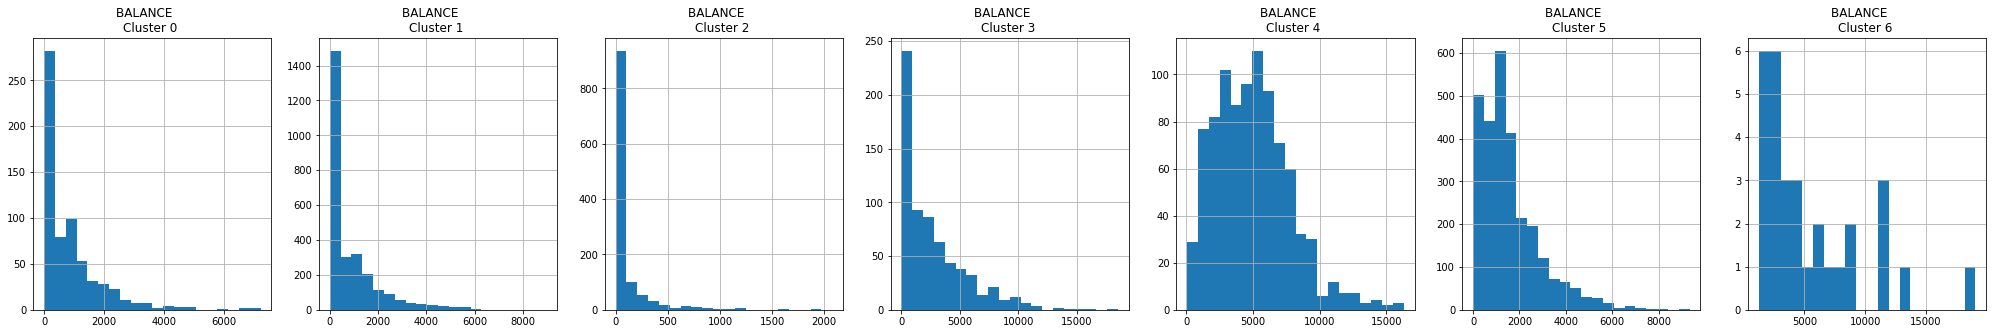

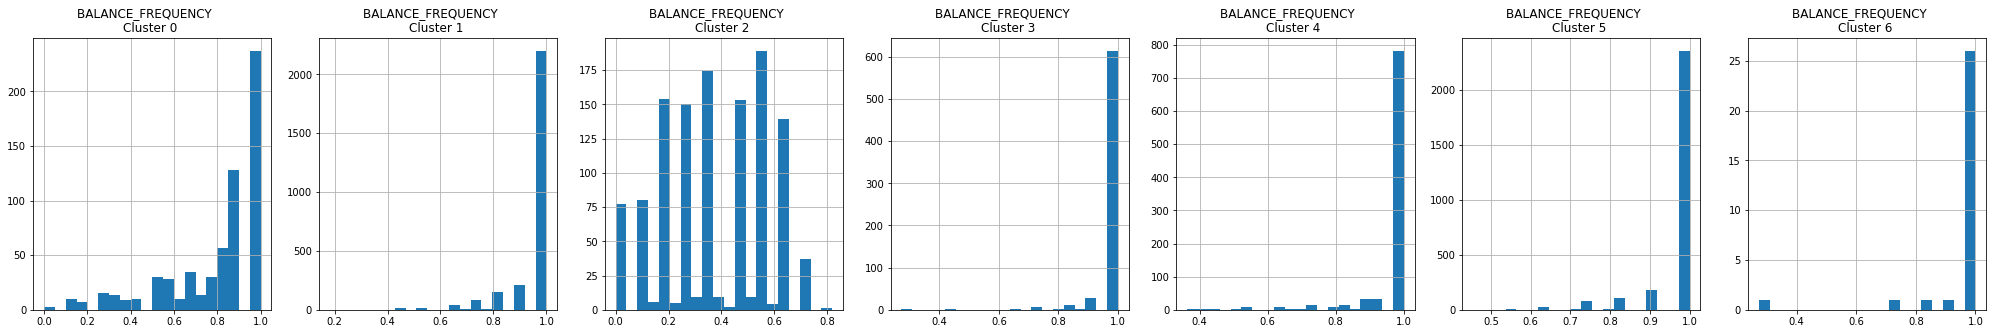

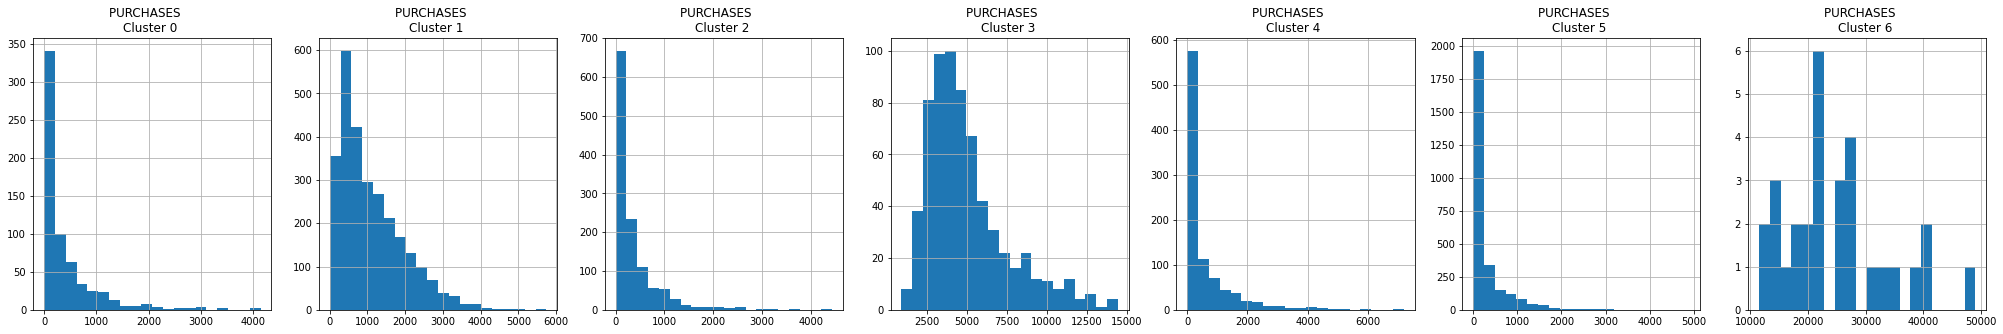

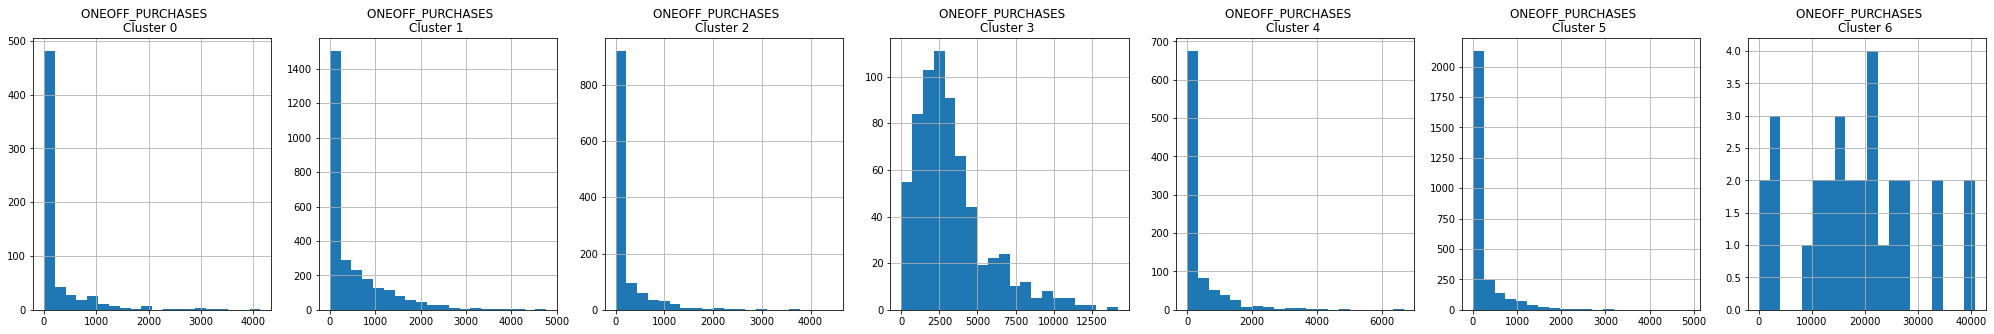

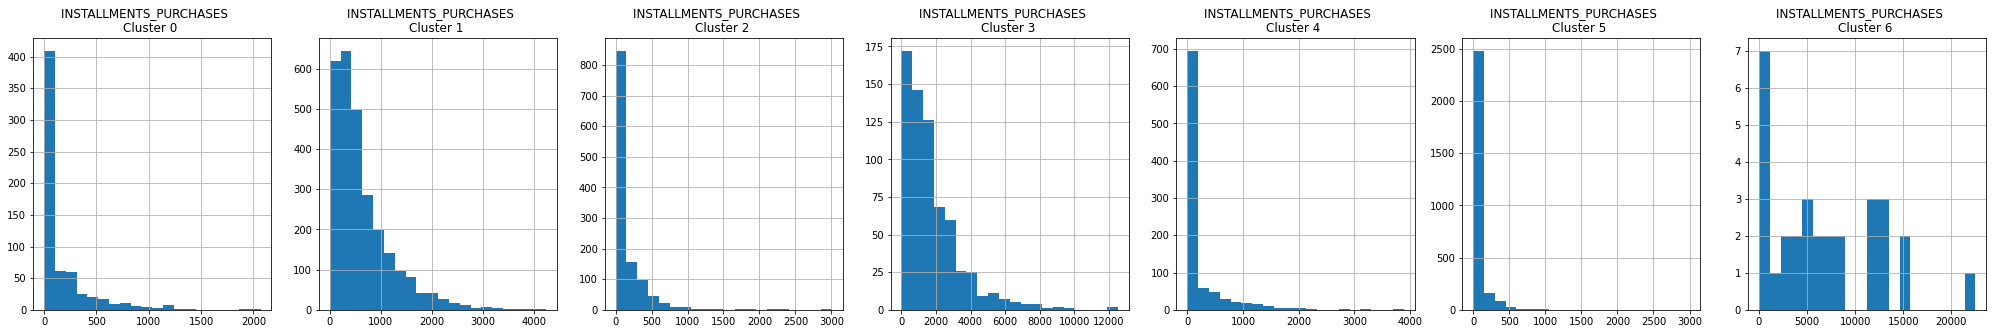

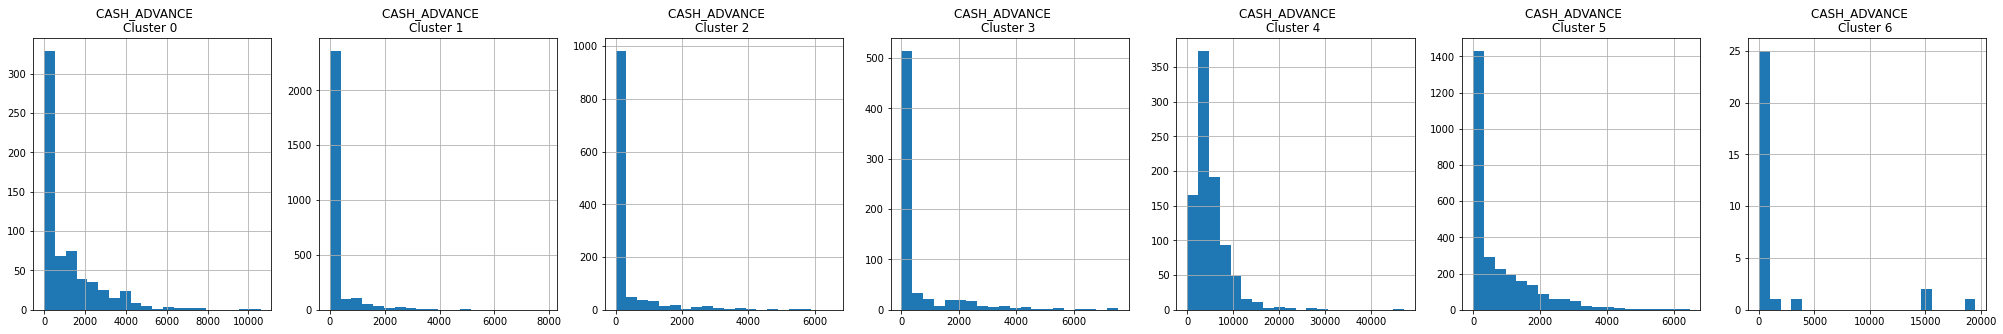

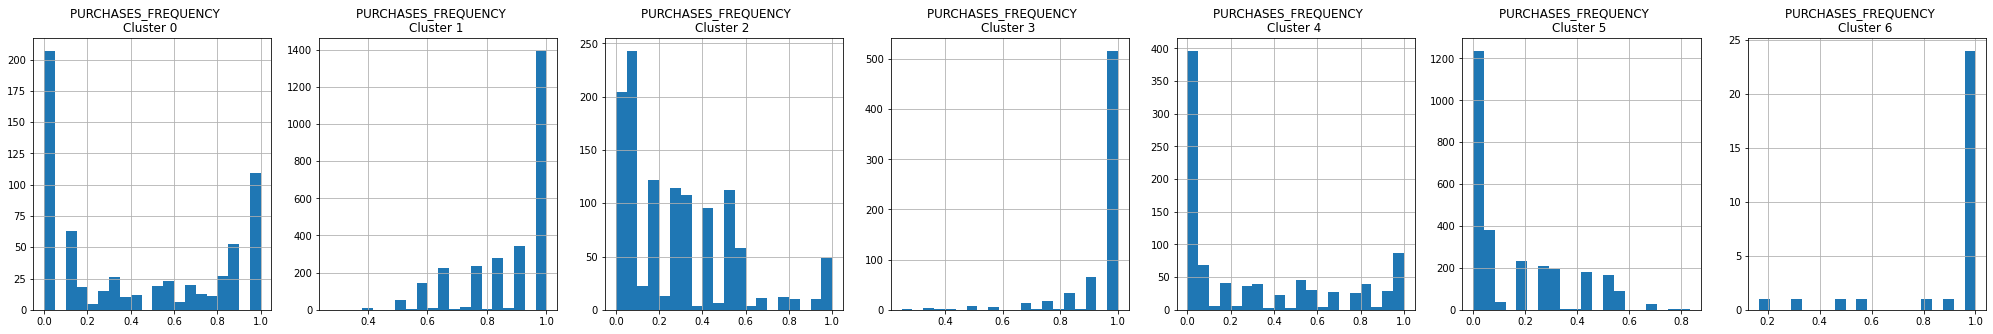

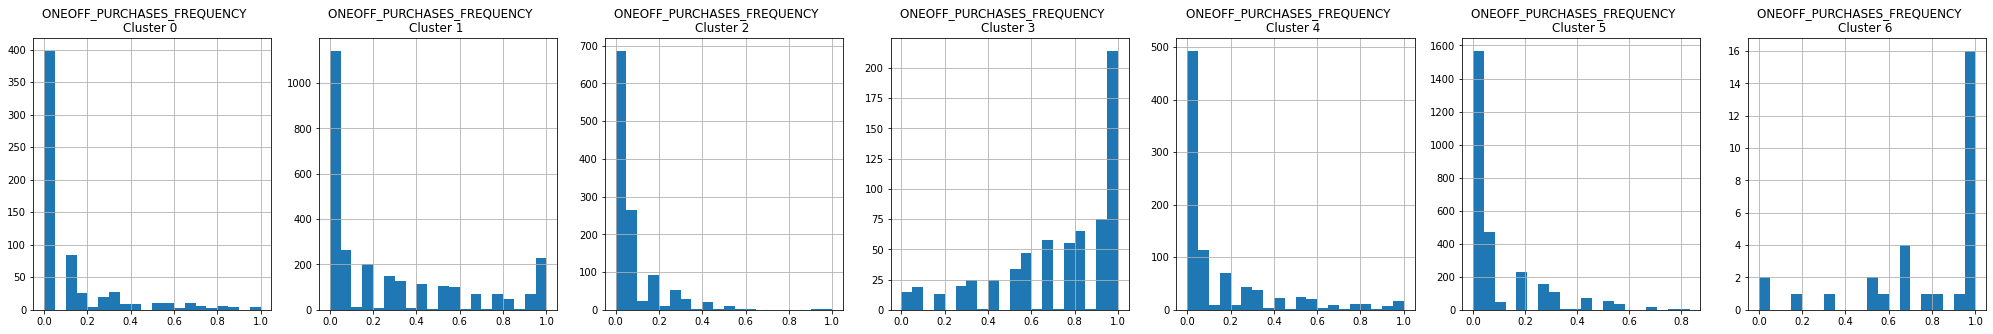

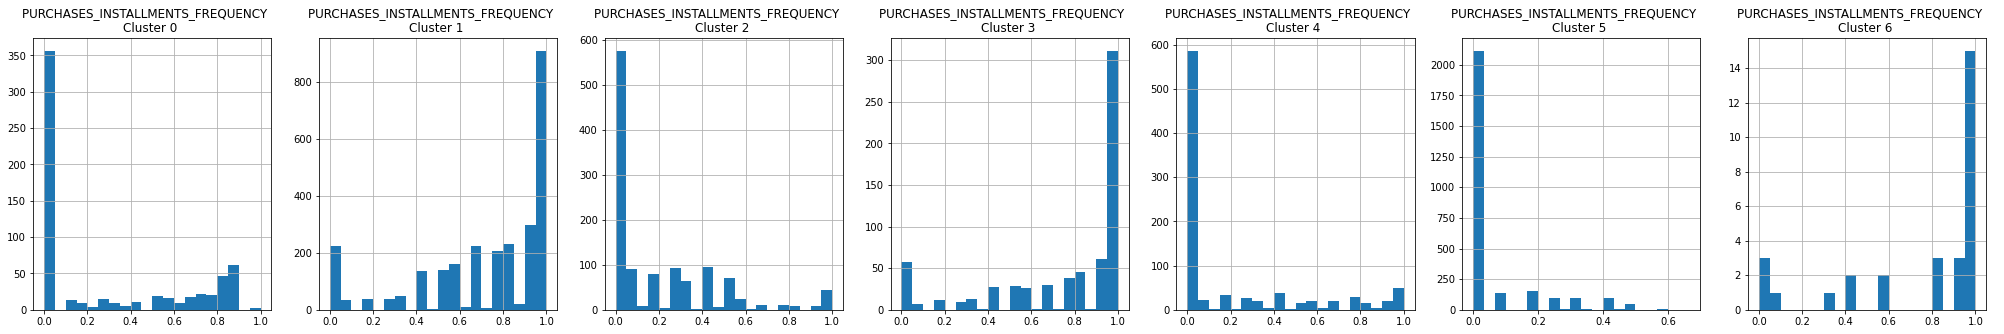

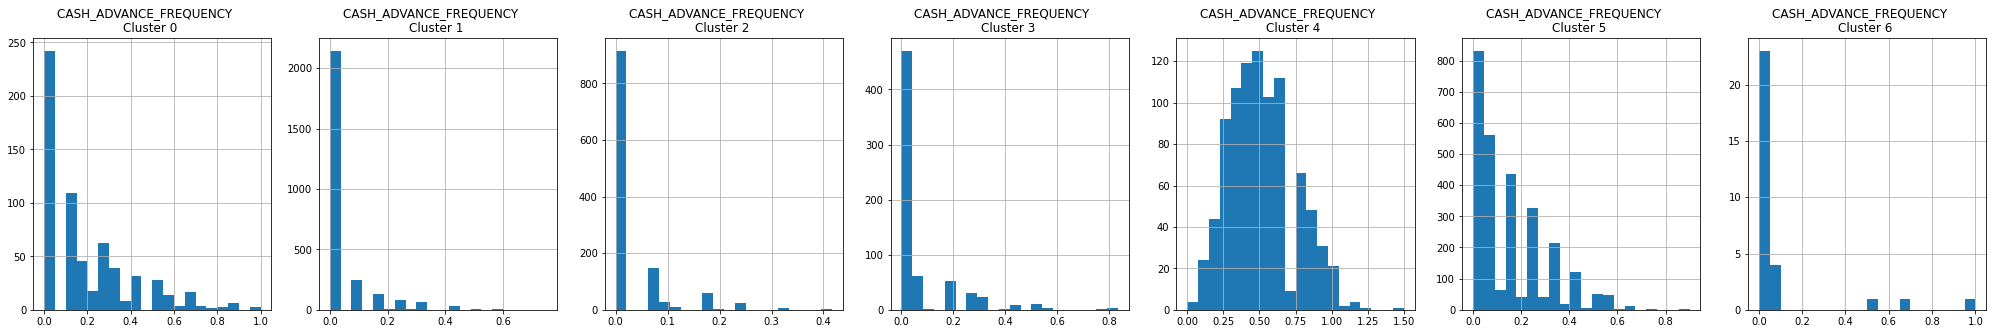

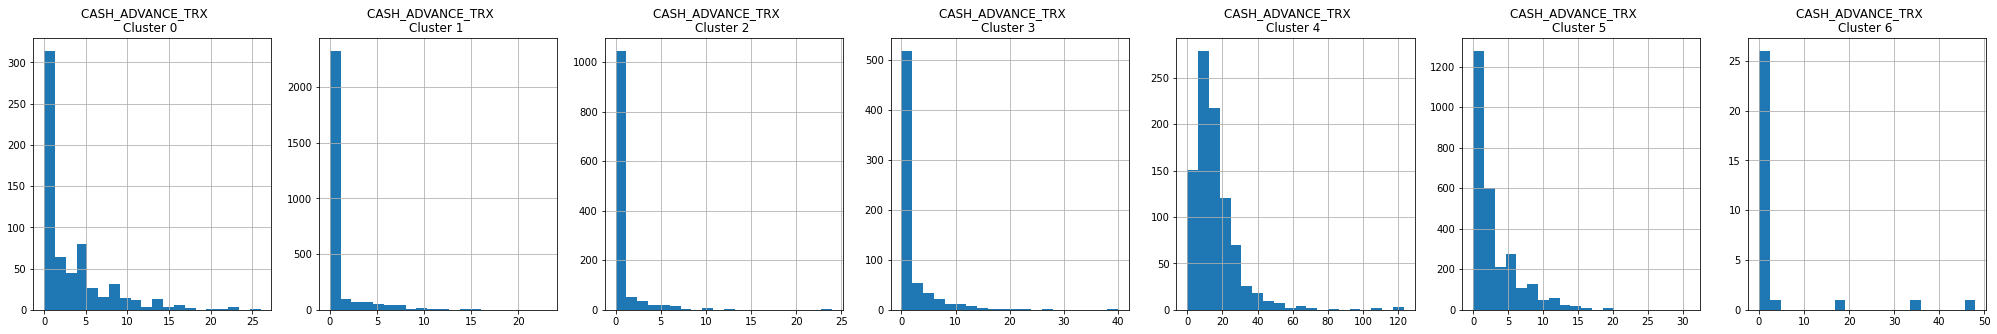

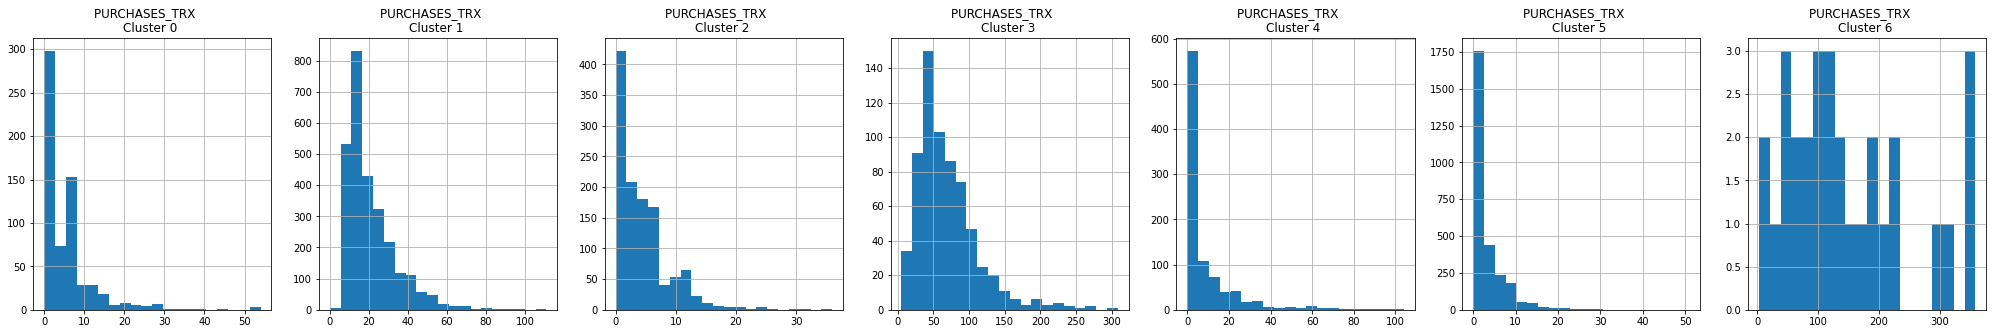

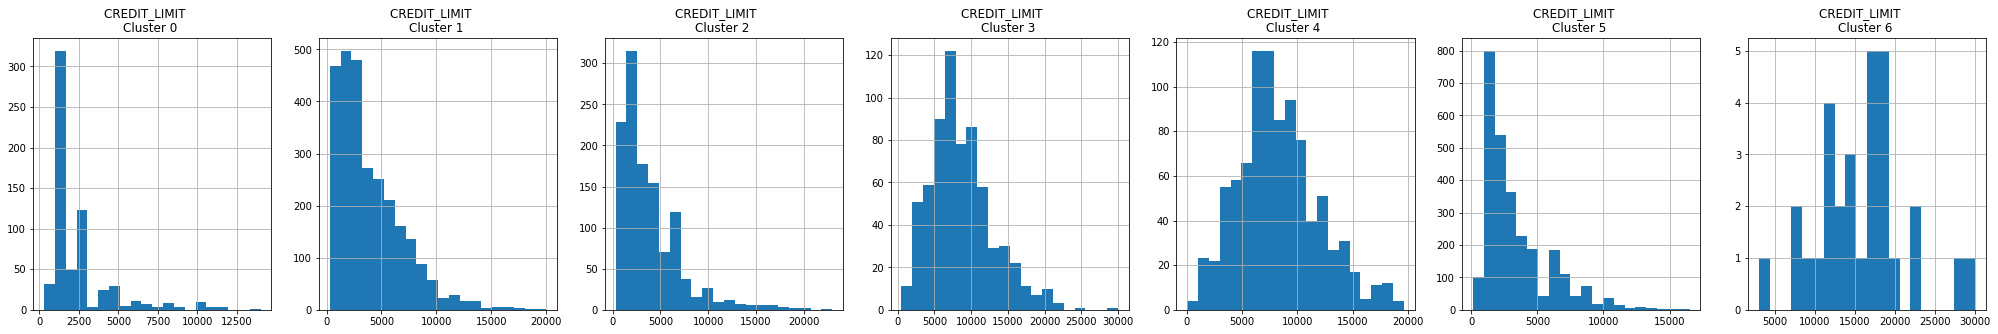

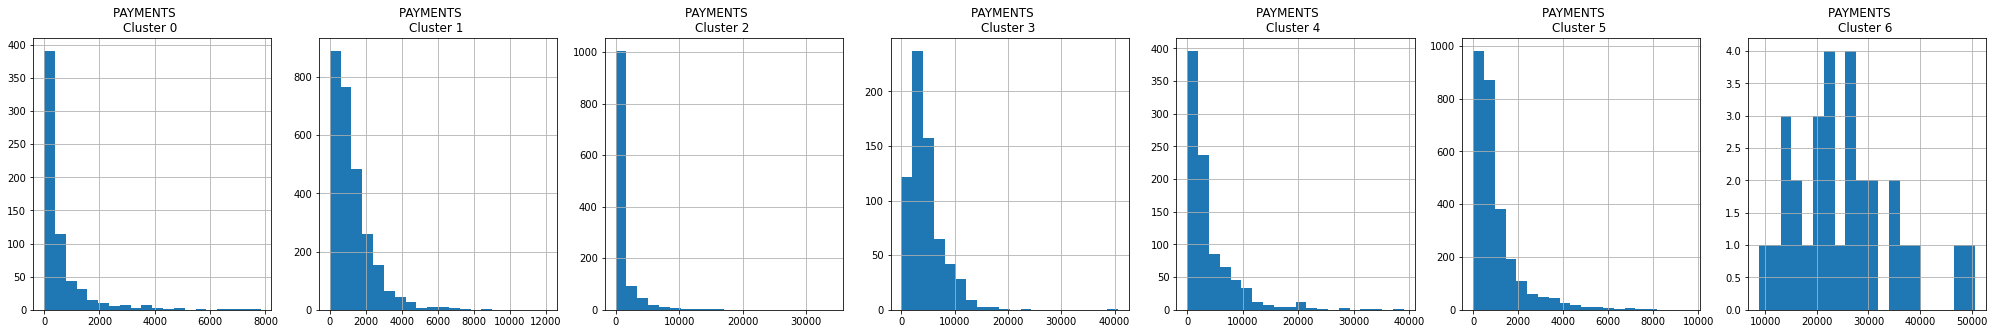

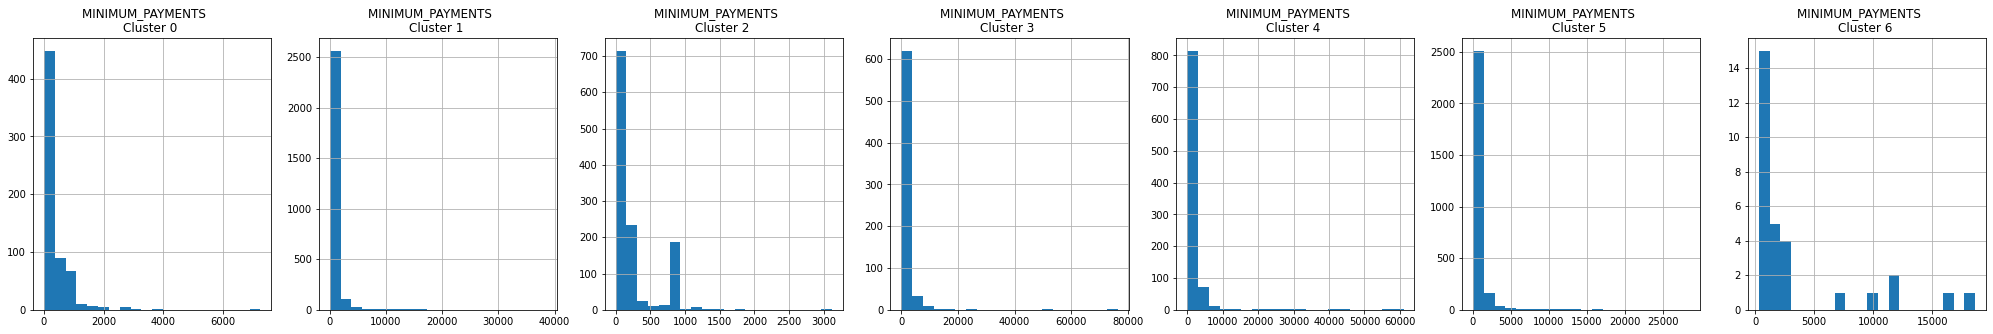

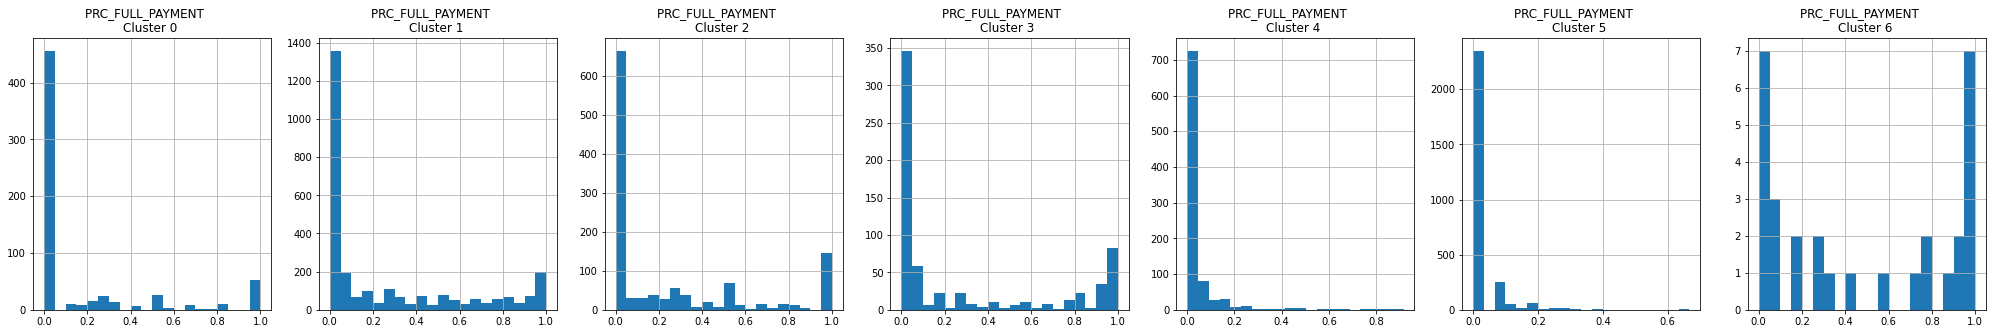

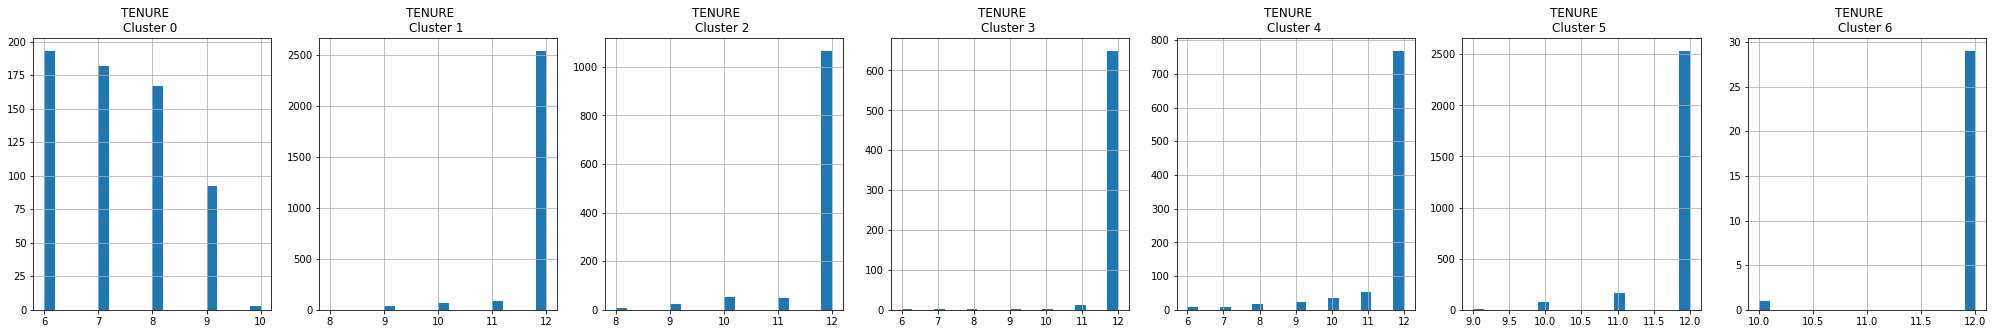

In [122]:
# Plotting the histogram of various clusters for better insights
for i in creditcard_df.columns:
  plt.figure(figsize = (35, 5))
  for j in range(7):
    plt.subplot(1,7,j+1)
    cluster = creditcard_df_cluster[creditcard_df_cluster['cluster'] == j]
    cluster[i].hist(bins = 20)
    plt.title('{}    \nCluster {} '.format(i,j))
  
  plt.show()

##Principal component analysis

In [78]:
# Obtain the principal components 
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(creditcard_df_scaled)
principal_comp

array([[-1.68222009, -1.07644614],
       [-1.13828865,  2.50646465],
       [ 0.96967601, -0.3834835 ],
       ...,
       [-0.92620477, -1.81078409],
       [-2.33655116, -0.6579733 ],
       [-0.55642296, -0.40047517]])

In [79]:
# Create a dataframe with the two components
pca_df = pd.DataFrame(data = principal_comp, columns =['pca1','pca2'])
pca_df.head()

,pca1,pca2
0,-1.682220,-1.076446
1,-1.138289,2.506465
2,0.969676,-0.383483
3,-0.873628,0.043181
4,-1.599434,-0.688580


In [80]:
# Concatenate the clusters labels to the dataframe
pca_df = pd.concat([pca_df,pd.DataFrame({'cluster':labels})], axis = 1)
pca_df.head()

,pca1,pca2,cluster
0,-1.682220,-1.076446,2
1,-1.138289,2.506465,4
2,0.969676,-0.383483,3
3,-0.873628,0.043181,2
4,-1.599434,-0.688580,2


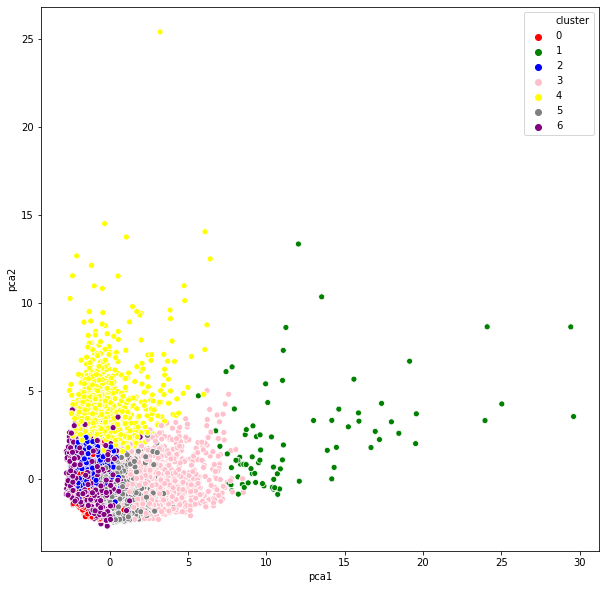

In [81]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="pca1", y="pca2", hue = "cluster", data = pca_df, palette =['red','green','blue','pink','yellow','gray','purple'])
plt.show()